# Magic Formula with a high F-Score
- 本策略使用之 finlab library 來自 hahow 課程 [用 Python 理財：打造小資族選股策略](https://hahow.in/courses/5a2170d5a6d4a5001ec3148d/)，提供台股股價、月季報數據擷取、回測框架等功能。因著作權法，本策略不提供 finlab library 之 source code。
- 若需暸解各財務指標詳細計算方法、採用會計科目，可利用 Quant Investing 網站之 [Glossary
](https://www.quant-investing.com/screener/glossary) 進行查詢。

### 1. 由於台股損益表表示方式為累進制，要計算當季損益，須扣除當年度前幾季的數值。

In [1]:
%matplotlib inline

import pandas as pd
import datetime

def to_seasonal(df):
    season4 = df[df.index.month == 3]
    season1 = df[df.index.month == 5]
    season2 = df[df.index.month == 8]
    season3 = df[df.index.month == 11]

    season1.index = season1.index.year
    season2.index = season2.index.year
    season3.index = season3.index.year
    season4.index = season4.index.year - 1

    newseason1 = season1
    newseason2 = season2 - season1.reindex_like(season2)
    newseason3 = season3 - season2.reindex_like(season3)
    newseason4 = season4 - season3.reindex_like(season4)

    newseason1.index = pd.to_datetime(newseason1.index.astype(str) + '-05-15')
    newseason2.index = pd.to_datetime(newseason2.index.astype(str) + '-08-14')
    newseason3.index = pd.to_datetime(newseason3.index.astype(str) + '-11-14')
    newseason4.index = pd.to_datetime((newseason4.index + 1).astype(str) + '-03-31')
    
    return newseason1.append(newseason2).append(newseason3).append(newseason4).sort_index()

### 2. 計算 Magic Formula 需要之指標

In [2]:
def total_assets(data, window):
    return data.get('資產總計', window).fillna(data.get('資產總額', window))

def ROIC(data):
    EBIT = data.get('繼續營業單位稅前淨利（淨損）', 1).iloc[-1]
    IC = total_assets(data, 1).iloc[-1] - data.get('流動負債合計', 1).fillna(data.get('流動負債總額', 1)).iloc[-1]
    return EBIT/IC

def ROIC_rankings(data):
    stocks = ROIC(data).sort_values(ascending=True)[lambda data: data > 0]
    return pd.Series(list(range(0, stocks.size)), index = stocks.index)

def earnings_yield(data):
    EBIT = data.get('繼續營業單位稅前淨利（淨損）', 1).iloc[-1]
    EV = data.get('股本合計', 1).iloc[-1]/10 * data.get('收盤價', 1).iloc[-1] + data.get('負債總計', 1).fillna(data.get('負債總額', 1)).iloc[-1] - data.get('現金及約當現金', 1).fillna(data.get('現金及約當現金合計', 1)).fillna(data.get('現金及約當現金總額', 1)).iloc[-1]
    return EBIT/EV

def earnings_yield_rankings(data):
    stocks = earnings_yield(data).sort_values(ascending=True)[lambda data: data > 0]
    return pd.Series(list(range(0, stocks.size)), index = stocks.index)

### 3. 實作 Magic Formula 策略
將 ROIC 排行與 Earnings Yield 排行相加後排序，剔除回測期間有減資的股票，選出排行前 10 檔股票。

In [3]:
def magic_formula(data):
    scores = ROIC_rankings(data) + earnings_yield_rankings(data)
    return scores.sort_values(ascending=False).drop(['2359','1516','2408','2408','2456','2459','2327','3046','5305','1410','2331','2476','3059','1315','2426','2444','1538','2375','1449','2438','2438','4930','1413','1513','3040','3536','3536','3536','9929','2434','6165','8261','2323','2375','3035','3380','2492','3049','1905','2472','3015','1109','1527','1416','2374','1603','3545','4306','6172','2017','2387','1456','5906','5906','8201','2327','2496','8070','2492','2314','3055','8271','2107','2349','2387','2364','2455','2612','3021','3149','1416','1809','2478','6283','2501','2358','9911','2028','2363','5259','3557','1325','1603','9928','1316','1457','1441','2609','2327','2337','2480','2373','2415','6192','8072','2492','3050','2316','2107','8033','2434','2387','6197','2340','2342','2477','1451','3557','1416','5525','2465','1109','1472','3026','3060','1475','5259','1418','2007','3046','1471','3312','5906','2614','2208','2022','8101','2419','1538','2349','3022','2436','3054','3532','3679','3702','9945','2456','1109','2458','8021','2317','8150','1423','2915','3593','1582','2321','3701','2329','2387','2404','1604','1529','2429','3056','5608'], errors='ignore').head(10)    

### 4. 回測
起始日為 2014-5-16，結束日為 2019-4-1，每個季報發布後一日做再平衡，不考慮手續費及股利。

2014-05-16 - 2014-08-15 報酬率: 7.26 % nstock 10
2014-08-15 - 2014-11-15 報酬率: -5.37 % nstock 10
2014-11-15 - 2015-04-01 報酬率: 23.25 % nstock 10
2015-04-01 - 2015-05-16 報酬率: 1.95 % nstock 10
2015-05-16 - 2015-08-15 報酬率: -10.09 % nstock 10
2015-08-15 - 2015-11-15 報酬率: 3.14 % nstock 10
2015-11-15 - 2016-04-01 報酬率: 2.48 % nstock 10
2016-04-01 - 2016-05-16 報酬率: -4.60 % nstock 10
2016-05-16 - 2016-08-15 報酬率: 5.38 % nstock 10
2016-08-15 - 2016-11-15 報酬率: -0.01 % nstock 10
2016-11-15 - 2017-04-01 報酬率: 19.75 % nstock 10
2017-04-01 - 2017-05-16 報酬率: -5.10 % nstock 10
2017-05-16 - 2017-08-15 報酬率: 0.14 % nstock 10
2017-08-15 - 2017-11-15 報酬率: 17.15 % nstock 10
2017-11-15 - 2018-04-01 報酬率: 2.80 % nstock 10
2018-04-01 - 2018-05-16 報酬率: -3.16 % nstock 10
2018-05-16 - 2018-08-15 報酬率: -5.68 % nstock 10
2018-08-15 - 2018-11-15 報酬率: -13.78 % nstock 10
2018-11-15 - 2019-04-01 報酬率: 18.21 % nstock 10
每次換手最大報酬 : 23.25 ％
每次換手最少報酬 : -13.78 ％


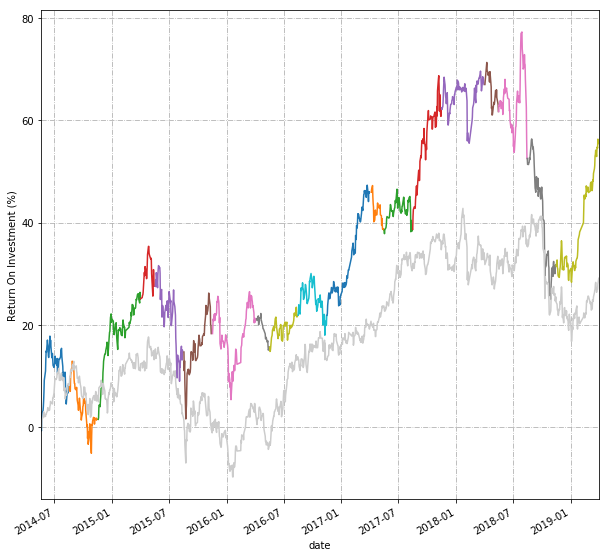

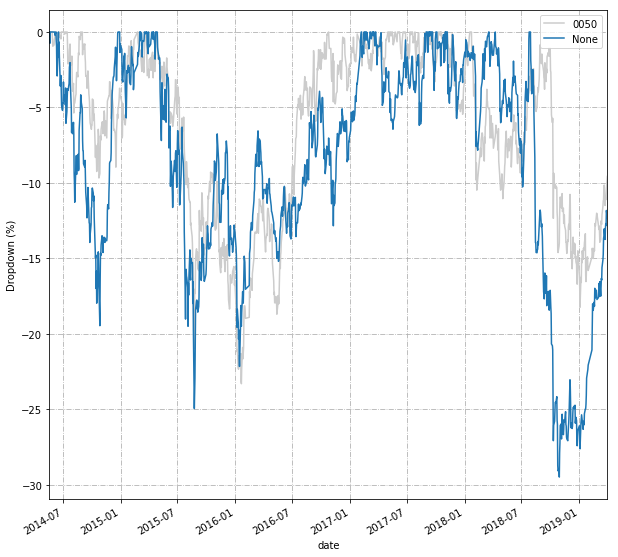

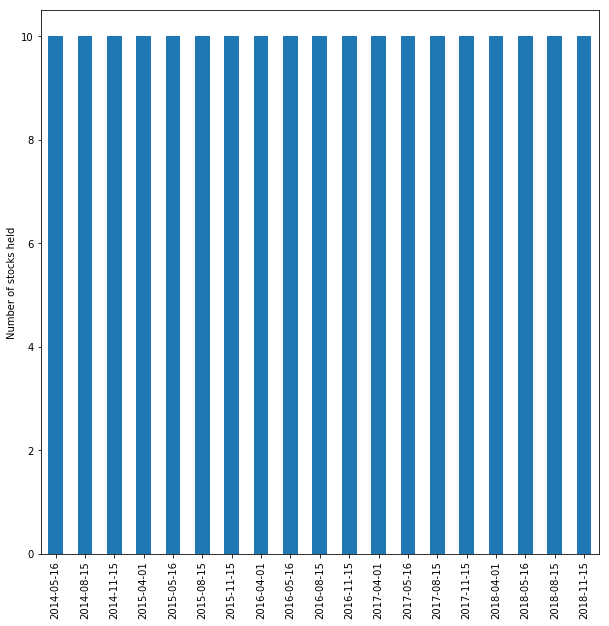

In [5]:
from finlab.backtest import backtest
from finlab.data import Data
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(10, 10)

data = Data()
data.col2table['折舊費用'] = 'cash_flows'
data.col2table['攤銷費用'] = 'cash_flows'

start_date = datetime.date(2014, 5, 16)
end_date = datetime.date(2019, 4, 1)

list_dates = [datetime.date(2014, 5, 16), datetime.date(2014, 8, 15), datetime.date(2014, 11, 15),
              datetime.date(2015, 4, 1), datetime.date(2015, 5, 16), datetime.date(2015, 8, 15), datetime.date(2015, 11, 15),
              datetime.date(2016, 4, 1), datetime.date(2016, 5, 16), datetime.date(2016, 8, 15), datetime.date(2016, 11, 15),
              datetime.date(2017, 4, 1), datetime.date(2017, 5, 16), datetime.date(2017, 8, 15), datetime.date(2017, 11, 15),
              datetime.date(2018, 4, 1), datetime.date(2018, 5, 16), datetime.date(2018, 8, 15), datetime.date(2018, 11, 15),
              datetime.date(2019, 4, 1)]

equality, transections = backtest(start_date, end_date, list_dates, magic_formula, data, stop_loss=None)

### 5.1 計算 F-Score 中之 Profitability 指標

In [6]:
def ROA(data):
    return data.get('本期淨利（淨損）', 1).iloc[-1] / total_assets(data, 1).iloc[-1]

def CFROA(data):
    return to_seasonal(data.get('營業活動之淨現金流入（流出）', 5)).iloc[-1] / total_assets(data, 1).iloc[-1]

def ROA_YoY(data):
    current_ROA = ROA(data)
    last_year_ROA = data.get('本期淨利（淨損）', 5).iloc[0] / total_assets(data, 5).iloc[0]
    return current_ROA - last_year_ROA

def CFROA_to_ROA(data):
    return CFROA(data) - ROA(data)

### 5.2 計算 F-Score 中之 Leverage, Liquidity and Source of Funds 指標

In [7]:
def gearing(data):
    long_term_debt = data.get('非流動負債合計', 5)
    average_total_assets = total_assets(data, 5)
    current_gearing = long_term_debt.iloc[-1] / average_total_assets.iloc[-1]
    lastYear_gearing = long_term_debt.iloc[0] / average_total_assets.iloc[0]
    return current_gearing - lastYear_gearing
    
def liquidity(data):
    assets = data.get('流動資產合計', 5)
    liabilities = data.get('流動負債合計', 5)
    current_liquidity = assets.iloc[-1] / liabilities.iloc[-1]
    last_year_liquidity = assets.iloc[0] / liabilities.iloc[0]
    return current_liquidity - last_year_liquidity

def shares_in_issue(data):
    shares_in_issue = data.get('股本合計', 5)
    return shares_in_issue.iloc[-1] - shares_in_issue.iloc[0]

### 5.3 計算 F-Score 中之 Operating Efficiency 指標

In [8]:
def gross_margin(data):
    gross_profit = data.get('營業毛利（毛損）淨額', 5)
    sales = data.get('當月營收', 16)
    current_gross_margin = gross_profit.iloc[-1] / sales.tail(4).sum()
    last_year_gross_margin = gross_profit.iloc[0] / sales.head(4).sum()
    return current_gross_margin - last_year_gross_margin
    
def asset_turnover(data):
    total_sales = data.get('當月營收', 16)
    ta = total_assets(data, 5)
    current_asset_turnover = total_sales.tail(4).sum() / ta.iloc[-1]
    last_year_asset_turnover = total_sales.head(4).sum() / ta.iloc[0]
    return current_asset_turnover - last_year_asset_turnover

### 5.4 將 F-Score 分數加總，滿分為 9 分

In [9]:
def f_score(data):
    return ROA(data).apply(lambda data: 1 if data > 0 else 0) + \
        CFROA(data).apply(lambda data: 1 if data > 0 else 0) + \
        ROA_YoY(data).apply(lambda data: 1 if data > 0 else 0) + \
        CFROA_to_ROA(data).apply(lambda data: 1 if data > 0 else 0) + \
        gearing(data).apply(lambda data: 1 if data < 0 else 0) + \
        liquidity(data).apply(lambda data: 1 if data > 0 else 0) + \
        shares_in_issue(data).apply(lambda data: 1 if data <= 0 else 0) + \
        gross_margin(data).apply(lambda data: 1 if data > 0 else 0) + \
        asset_turnover(data).apply(lambda data: 1 if data > 0 else 0)

### 6. 實作 MF/Piot 策略
先篩選出 F-Score ≥ 8 分的股票，再根據神奇公式選出排行前 10 檔股票。

In [10]:
def mf_piot(data):
    fs = f_score(data)
    mf = ROIC_rankings(data) + earnings_yield_rankings(data)
    stocks = pd.concat([fs, mf], axis=1, keys=['fs', 'mf'])
    return stocks[stocks.fs >= 8].sort_values(ascending=False, by='mf').drop(['2359','1516','2408','2408','2456','2459','2327','3046','5305','1410','2331','2476','3059','1315','2426','2444','1538','2375','1449','2438','2438','4930','1413','1513','3040','3536','3536','3536','9929','2434','6165','8261','2323','2375','3035','3380','2492','3049','1905','2472','3015','1109','1527','1416','2374','1603','3545','4306','6172','2017','2387','1456','5906','5906','8201','2327','2496','8070','2492','2314','3055','8271','2107','2349','2387','2364','2455','2612','3021','3149','1416','1809','2478','6283','2501','2358','9911','2028','2363','5259','3557','1325','1603','9928','1316','1457','1441','2609','2327','2337','2480','2373','2415','6192','8072','2492','3050','2316','2107','8033','2434','2387','6197','2340','2342','2477','1451','3557','1416','5525','2465','1109','1472','3026','3060','1475','5259','1418','2007','3046','1471','3312','5906','2614','2208','2022','8101','2419','1538','2349','3022','2436','3054','3532','3679','3702','9945','2456','1109','2458','8021','2317','8150','1423','2915','3593','1582','2321','3701','2329','2387','2404','1604','1529','2429','3056','5608'], errors='ignore').head(10)

### 7. 再次回測

2014-05-16 - 2014-08-15 報酬率: 10.60 % nstock 10
2014-08-15 - 2014-11-15 報酬率: -9.33 % nstock 10
2014-11-15 - 2015-04-01 報酬率: 23.31 % nstock 10
2015-04-01 - 2015-05-16 報酬率: 2.76 % nstock 10
2015-05-16 - 2015-08-15 報酬率: -10.41 % nstock 10
2015-08-15 - 2015-11-15 報酬率: 1.95 % nstock 10
2015-11-15 - 2016-04-01 報酬率: 3.32 % nstock 10
2016-04-01 - 2016-05-16 報酬率: -2.80 % nstock 10
2016-05-16 - 2016-08-15 報酬率: 13.41 % nstock 10
2016-08-15 - 2016-11-15 報酬率: -4.11 % nstock 10
2016-11-15 - 2017-04-01 報酬率: 21.42 % nstock 10
2017-04-01 - 2017-05-16 報酬率: -2.43 % nstock 10
2017-05-16 - 2017-08-15 報酬率: 10.22 % nstock 10
2017-08-15 - 2017-11-15 報酬率: 4.34 % nstock 10
2017-11-15 - 2018-04-01 報酬率: 13.14 % nstock 10
2018-04-01 - 2018-05-16 報酬率: 6.79 % nstock 10
2018-05-16 - 2018-08-15 報酬率: -2.04 % nstock 10
2018-08-15 - 2018-11-15 報酬率: -8.60 % nstock 10
2018-11-15 - 2019-04-01 報酬率: 30.77 % nstock 10
每次換手最大報酬 : 30.77 ％
每次換手最少報酬 : -10.41 ％


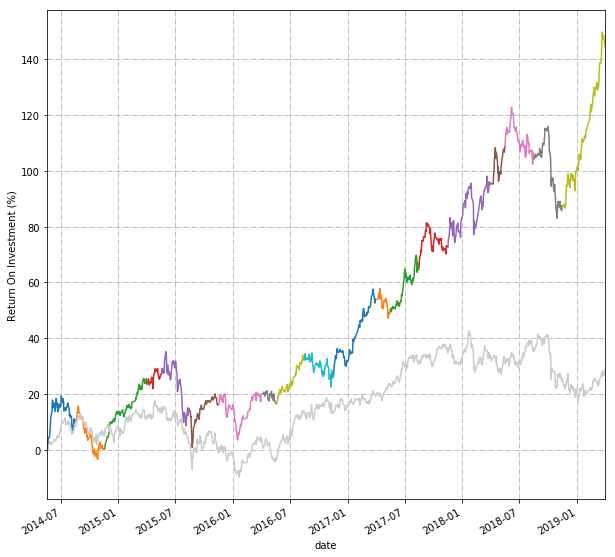

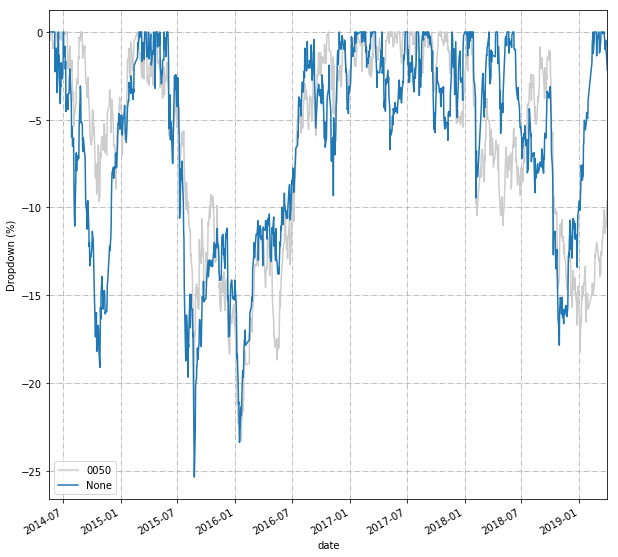

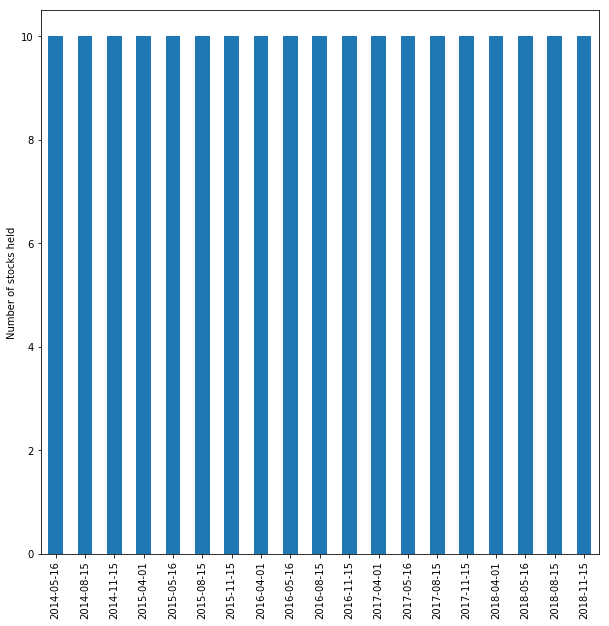

In [12]:
equality, transections = backtest(start_date, end_date, list_dates, mf_piot, data, stop_loss=None)

### 8. 加入優化策略指標

In [13]:
def 月營收年增率(data):
    return data.get('去年同月增減(%)', 1).iloc[-1]

def 營業利益成長率(data):
    營業利益 = data.get('營業利益（損失）', 5)
    return 營業利益.iloc[-1] / 營業利益.iloc[-5] - 1

def FCF(data):
    income = to_seasonal(data.get('營業活動之淨現金流入（流出）', 5))
    outcome = to_seasonal(data.get('投資活動之淨現金流入（流出）', 5))
    return (income + outcome).iloc[-1]

### 9. 實作 MF/Piot 優化策略

In [14]:
def mf_piot_optimize(data):
    fs = f_score(data)
    mf = ROIC_rankings(data) + earnings_yield_rankings(data)
    stocks = pd.concat([fs, mf, 月營收年增率(data), 營業利益成長率(data), FCF(data)], axis=1, keys=['fs', 'mf', '月營收年增率', '營業利益成長率', 'FCF'])
    return stocks[stocks.fs >= 8][stocks.月營收年增率 > 0][stocks.營業利益成長率 > 0][stocks.FCF > 0].sort_values(ascending=False, by='mf').drop(['2359','1516','2408','2408','2456','2459','2327','3046','5305','1410','2331','2476','3059','1315','2426','2444','1538','2375','1449','2438','2438','4930','1413','1513','3040','3536','3536','3536','9929','2434','6165','8261','2323','2375','3035','3380','2492','3049','1905','2472','3015','1109','1527','1416','2374','1603','3545','4306','6172','2017','2387','1456','5906','5906','8201','2327','2496','8070','2492','2314','3055','8271','2107','2349','2387','2364','2455','2612','3021','3149','1416','1809','2478','6283','2501','2358','9911','2028','2363','5259','3557','1325','1603','9928','1316','1457','1441','2609','2327','2337','2480','2373','2415','6192','8072','2492','3050','2316','2107','8033','2434','2387','6197','2340','2342','2477','1451','3557','1416','5525','2465','1109','1472','3026','3060','1475','5259','1418','2007','3046','1471','3312','5906','2614','2208','2022','8101','2419','1538','2349','3022','2436','3054','3532','3679','3702','9945','2456','1109','2458','8021','2317','8150','1423','2915','3593','1582','2321','3701','2329','2387','2404','1604','1529','2429','3056','5608'], errors='ignore').head(10)

### 10. 最後回測

In [18]:
import warnings 
warnings.simplefilter('ignore')

2014-05-16 - 2014-08-15 報酬率: 2.29 % nstock 10
2014-08-15 - 2014-11-15 報酬率: -8.34 % nstock 10
2014-11-15 - 2015-04-01 報酬率: 20.47 % nstock 10
2015-04-01 - 2015-05-16 報酬率: 5.67 % nstock 10
2015-05-16 - 2015-08-15 報酬率: -0.56 % nstock 10
2015-08-15 - 2015-11-15 報酬率: 18.48 % nstock 8
2015-11-15 - 2016-04-01 報酬率: 6.79 % nstock 10
2016-04-01 - 2016-05-16 報酬率: -5.23 % nstock 10
2016-05-16 - 2016-08-15 報酬率: 10.62 % nstock 10
2016-08-15 - 2016-11-15 報酬率: -4.85 % nstock 10
2016-11-15 - 2017-04-01 報酬率: 12.33 % nstock 10
2017-04-01 - 2017-05-16 報酬率: 0.77 % nstock 10
2017-05-16 - 2017-08-15 報酬率: 9.32 % nstock 10
2017-08-15 - 2017-11-15 報酬率: 13.20 % nstock 10
2017-11-15 - 2018-04-01 報酬率: 19.89 % nstock 10
2018-04-01 - 2018-05-16 報酬率: 3.94 % nstock 10
2018-05-16 - 2018-08-15 報酬率: 0.91 % nstock 10
2018-08-15 - 2018-11-15 報酬率: -6.04 % nstock 10
2018-11-15 - 2019-04-01 報酬率: 21.91 % nstock 10
每次換手最大報酬 : 21.91 ％
每次換手最少報酬 : -8.34 ％


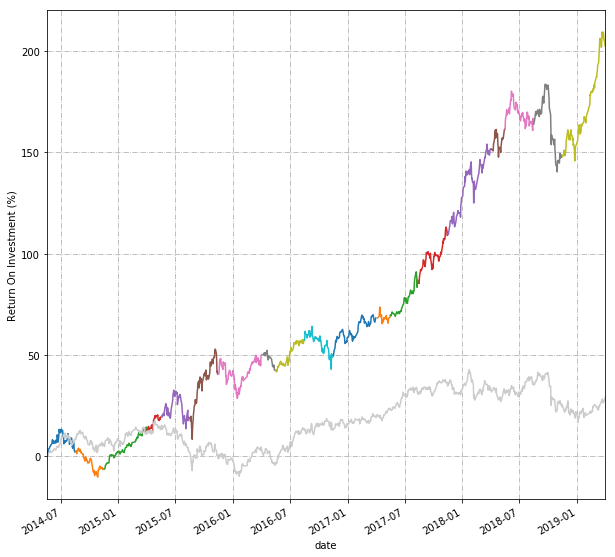

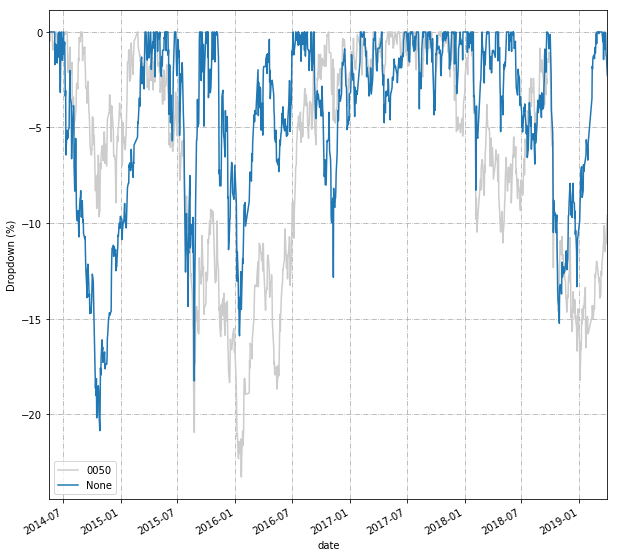

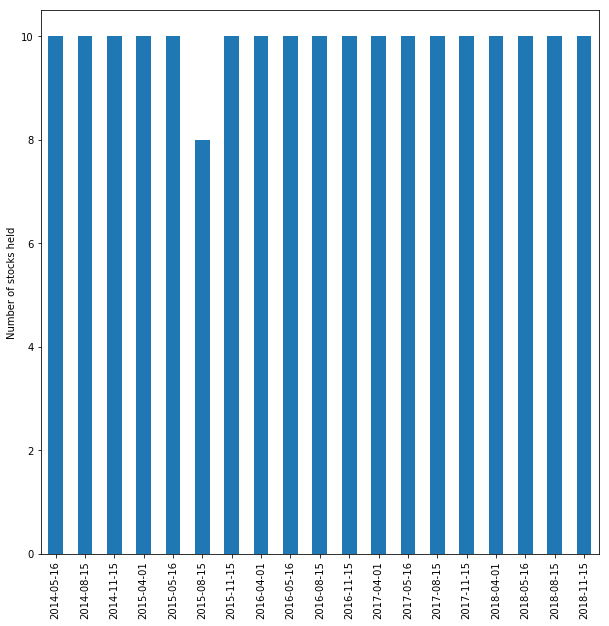

In [19]:
equality, transections = backtest(start_date, end_date, list_dates, mf_piot_optimize, data, stop_loss=None)